## Installation

In [71]:
!pip install pandas
!pip install pystan==2.19.1.1
!pip install prophet
!pip install boto3

  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Preparing metadata (setup.py) ... done
  Using cached cython-3.1.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.5 kB)
Using cached cython-3.1.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.2 MB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [3 lines of output]
      /tmp/pip-install-_1drs88r/pystan_a2d944e2bba240c187705576c132b06f/setup.py:61: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
        self.version = node.value.s
      Cython>=0.22 and NumPy are required.
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pystan
  Running setup.py clean for pystan
Failed to build pystan
ERROR: Failed to build installable wheels for some pyproject.toml based projects (pystan)


In [72]:
import pandas as pd
from prophet import Prophet
import boto3
import numpy as np
import os

## Take data from bucket

In [73]:
bucket = 'thedogspaw-small-forecast-data'  # <--- s3 bucket

# Connect to S3
s3 = boto3.client('s3')

def s3_get(key, local):
    s3.download_file(bucket, key, local)
    
s3_get('datasets/thedogspaw_phppos_sales.csv',         '/tmp/sales.csv')
s3_get('datasets/thedogspaw_phppos_sales_items.csv',   '/tmp/sales_items.csv')
s3_get('datasets/thedogspaw_phppos_variations_combined.csv', '/tmp/variations_combined.csv')

### Read data from bucket

In [74]:
sales_df = pd.read_csv(
    '/tmp/sales.csv',
    usecols=['sale_id', 'sale_time',  'location_id'],
    parse_dates=['sale_time'],
    low_memory=False
)

sales_items_df = pd.read_csv(
    '/tmp/sales_items.csv',
    usecols=['sale_id', 'item_variation_id', 'quantity_purchased'],
    low_memory=False
)

variations_combined_df = pd.read_csv('/tmp/variations_combined.csv')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)   # set to None to show all rows if needed

display(sales_items_df.head())

,sale_id,item_variation_id,quantity_purchased
0,1,NaN,1.0
1,2,NaN,1.0
2,3,NaN,1.0
3,4,NaN,1.0
4,5,NaN,1.0


In [75]:
print(sales_df.columns)
print(sales_items_df.columns)

Index(['sale_time', 'sale_id', 'location_id'], dtype='object')
Index(['sale_id', 'item_variation_id', 'quantity_purchased'], dtype='object')


## We take quantity_purchased from sales_items_df We take sale_time from sales_df

In [76]:
sales_items_with_time = sales_items_df.merge(
    sales_df[['sale_id', 'sale_time']],
    on='sale_id',
    how='left'
)

print(sales_items_with_time.columns)

Index(['sale_id', 'item_variation_id', 'quantity_purchased', 'sale_time'], dtype='object')


## Add location and names from variations_combined_df

In [77]:
combined_df = sales_items_with_time.merge(
    variations_combined_df[['item_variation_id', 'location_id', 'variation_name', 'name']].drop_duplicates(),
    on='item_variation_id',
    how='left'
)

print(combined_df.columns)

Index(['sale_id', 'item_variation_id', 'quantity_purchased', 'sale_time',
       'location_id', 'variation_name', 'name'],
      dtype='object')


## Create a daily date column

In [78]:
combined_df['sale_date'] = pd.to_datetime(combined_df['sale_time']).dt.date

## combined_df will have all sales log. Including item_variation_id that are NaN

In [79]:
combined_df.sample(n=5)

,sale_id,item_variation_id,quantity_purchased,sale_time,location_id,variation_name,name,sale_date
69176,28898,NaN,1.0,2015-11-18 14:07:28,NaN,NaN,NaN,2015-11-18
290022,115696,NaN,1.0,2021-12-06 16:25:06,NaN,NaN,NaN,2021-12-06
197718,78561,NaN,1.0,2019-08-26 15:33:38,NaN,NaN,NaN,2019-08-26
66901,27942,NaN,1.0,2015-10-18 15:05:58,NaN,NaN,NaN,2015-10-18
470057,183918,NaN,-1.0,2024-08-24 10:37:48,NaN,NaN,NaN,2024-08-24


## Aggregate quantity sold per day, per variation, per location, with readable names
## The agg_df will ONLY have sales log that have item_variation_id filled

In [80]:
agg_df = combined_df.groupby(
    ['sale_date', 'item_variation_id', 'location_id', 'variation_name', 'name']
)['quantity_purchased'].sum().reset_index()
agg_df.tail()

,sale_date,item_variation_id,location_id,variation_name,name,quantity_purchased
3045,2025-05-23,10.0,1.0,Prices: 19.99,Bakery,2.0
3046,2025-05-23,10.0,2.0,Prices: 19.99,Bakery,2.0
3047,2025-05-23,13.0,1.0,Prices: 35.99,Bakery,1.0
3048,2025-05-23,17.0,1.0,Prices: 25.99,Bakery,1.0
3049,2025-05-23,17.0,2.0,Prices: 25.99,Bakery,1.0


## track product return (barangnya di return)

In [81]:
# track when does those returns happening if want to print
returns = agg_df[agg_df['quantity_purchased'] < 0]

# exclude those negative (barang di return) value from df
agg_df = agg_df[agg_df['quantity_purchased'] >= 0]

display(returns.head())

,sale_date,item_variation_id,location_id,variation_name,name,quantity_purchased
629,2024-08-04,17.0,1.0,Prices: 25.99,Bakery,-1.0
630,2024-08-04,17.0,2.0,Prices: 25.99,Bakery,-1.0
821,2024-08-29,7.0,1.0,Prices: 6.99,Bakery,-2.0
822,2024-08-29,7.0,2.0,Prices: 6.99,Bakery,-2.0


### Can try to check the negative row by running the following cell

In [82]:
recent_daily_var_sales.iloc[[629]]

,date,variation_id,location_id,variation_name,name,y
631,2024-08-05,7.0,1.0,Prices: 6.99,Bakery,2.0


## After excluding returned product, make a new table with renamed columns

In [83]:
recent_daily_var_sales = agg_df.rename(
    columns={
        'sale_date': 'date',
        'item_variation_id': 'variation_id',
        'quantity_purchased': 'y'
    }
)
recent_daily_var_sales.tail()

,date,variation_id,location_id,variation_name,name,y
3045,2025-05-23,10.0,1.0,Prices: 19.99,Bakery,2.0
3046,2025-05-23,10.0,2.0,Prices: 19.99,Bakery,2.0
3047,2025-05-23,13.0,1.0,Prices: 35.99,Bakery,1.0
3048,2025-05-23,17.0,1.0,Prices: 25.99,Bakery,1.0
3049,2025-05-23,17.0,2.0,Prices: 25.99,Bakery,1.0


## change 'date' field to have datetime datatype instead of object or str
## Filter the recent_daily_var_sales to the last 12 months to prep for inference

In [84]:
# Make sure 'date' is datetime
recent_daily_var_sales['date'] = pd.to_datetime(recent_daily_var_sales['date'])
latest_date = recent_daily_var_sales['date'].max()
cutoff_date = latest_date - pd.DateOffset(months=12)

# Filter for the last 12 months
recent_12m = recent_daily_var_sales[recent_daily_var_sales['date'] >= cutoff_date].copy()


In [85]:
# The DataFrame starts at row 96 because rows 1–95 correspond to dates earlier than the 12-month window
recent_12m.head()

,date,variation_id,location_id,variation_name,name,y
96,2024-05-23,2.0,1.0,Prices: 1.99,Bakery,8.0
97,2024-05-23,2.0,2.0,Prices: 1.99,Bakery,8.0
98,2024-05-23,4.0,1.0,Prices: 3.99,Bakery,2.0
99,2024-05-23,4.0,2.0,Prices: 3.99,Bakery,2.0
100,2024-05-23,5.0,1.0,Prices: 4.99,Bakery,2.0


# 1. Consecutive sales days: Not just “20 days with sales,” but “20 days spread across X weeks” (to avoid all sales in one burst).

## Add a week number column

In [86]:
recent_12m['sales_week'] = recent_12m['date'].dt.isocalendar().week
recent_12m['sales_year'] = recent_12m['date'].dt.isocalendar().year

## Count unique sales days and unique (year, week) combos per variation/location

In [87]:
history_quality = (
    recent_12m.groupby(['location_id', 'variation_id'])
    .agg(
        num_days_with_sales=('date', 'nunique'),
        num_weeks_with_sales=('sales_week', 'nunique'),
        num_years_with_sales=('sales_year', 'nunique')  # Useful for data that spans New Year
    )
    .reset_index()
)

## Merge readable names from recent_12m (drop_duplicates to avoid extra rows)

In [88]:
history_quality = history_quality.merge(
    recent_12m[['location_id', 'variation_id', 'variation_name', 'name']].drop_duplicates(),
    on=['location_id', 'variation_id'],
    how='left'
)

## we can require, for example, at least 20 days of sales AND sales in at least 4 different weeks

In [89]:
min_days = 20
min_weeks = 4

In [90]:
history_quality['enough_history'] = (
    (history_quality['num_days_with_sales'] >= min_days) &
    (history_quality['num_weeks_with_sales'] >= min_weeks)
)

In [91]:
display(history_quality.head(30))

,location_id,variation_id,num_days_with_sales,num_weeks_with_sales,num_years_with_sales,variation_name,name,enough_history
0,1.0,1.0,12,10,2,Prices: .99,Bakery,False
1,1.0,2.0,172,51,2,Prices: 1.99,Bakery,True
2,1.0,3.0,134,49,2,Prices: 2.99,Bakery,True
3,1.0,4.0,163,50,2,Prices: 3.99,Bakery,True
4,1.0,5.0,202,52,2,Prices: 4.99,Bakery,True
5,1.0,6.0,117,45,2,Prices: 5.99,Bakery,True
6,1.0,7.0,290,52,2,Prices: 6.99,Bakery,True
7,1.0,8.0,51,30,2,Prices: 7.99,Bakery,True
8,1.0,9.0,124,45,2,Prices: 13.99,Bakery,True
9,1.0,10.0,35,25,2,Prices: 19.99,Bakery,True


## Give more stock to volatite product
## Calculate mean and std per item/location, and the CV

In [92]:
demand_stats = (
    recent_12m.groupby(['location_id', 'variation_id'])['y']
    .agg(['mean', 'std'])
    .reset_index()
)
demand_stats['cv'] = demand_stats['std'] / demand_stats['mean']

# Assign z-score based on volatility
def select_z(cv):
    if cv < 0.5:
        return 1.65  # 95% service
    elif cv < 1.0:
        return 2.0   # 97.5% service
    else:
        return 2.33  # 99% service

demand_stats['z_score'] = demand_stats['cv'].apply(select_z)


## Merge z_score and cv into history_quality DataFrame

In [93]:
history_quality = history_quality.merge(
    demand_stats[['location_id', 'variation_id', 'cv', 'z_score']],
    on=['location_id', 'variation_id'],
    how='left'
)

display(history_quality.head(20))

,location_id,variation_id,num_days_with_sales,num_weeks_with_sales,num_years_with_sales,variation_name,name,enough_history,cv,z_score
0,1.0,1.0,12,10,2,Prices: .99,Bakery,False,1.005907,2.33
1,1.0,2.0,172,51,2,Prices: 1.99,Bakery,True,0.934620,2.00
2,1.0,3.0,134,49,2,Prices: 2.99,Bakery,True,1.002136,2.33
3,1.0,4.0,163,50,2,Prices: 3.99,Bakery,True,0.696672,2.00
4,1.0,5.0,202,52,2,Prices: 4.99,Bakery,True,0.867315,2.00
5,1.0,6.0,117,45,2,Prices: 5.99,Bakery,True,0.950420,2.00
6,1.0,7.0,290,52,2,Prices: 6.99,Bakery,True,0.771376,2.00
7,1.0,8.0,51,30,2,Prices: 7.99,Bakery,True,0.842763,2.00
8,1.0,9.0,124,45,2,Prices: 13.99,Bakery,True,0.527475,2.00
9,1.0,10.0,35,25,2,Prices: 19.99,Bakery,True,0.222774,1.65


## Now we need to groupby the recent_12m table by location_id and variation_id. sum up the 'y' (quantity sold) and attach the "enough_history" column beside it

### aggregate daily sales per variation/location:

In [94]:
grouped_sales = (
    recent_12m.groupby(['date', 'location_id', 'variation_id'])
    .agg({'y': 'sum'})   # or use {'quantity_purchased': 'sum'} and rename to y
    .reset_index()
)

### Merge in enough_history from history_quality table

In [95]:
grouped_sales = grouped_sales.merge(
    history_quality[['location_id', 'variation_id', 'enough_history']],
    on=['location_id', 'variation_id'],
    how='left'
)

## Main Inference

In [106]:
lead_time_days = 7
results = []
# prophet_forecasts dict is for testing purposes
prophet_forecasts = {}

# We loop over each group (one group = one item-location pair).
# we use .iloc[0] to get the flag for that whole group.
# If that flag is True, we proceed with Prophet on all the dates in that group.
# If False, then we use a fallback.

for (loc, var), group in grouped_sales.groupby(['location_id', 'variation_id']):
    enough = group['enough_history'].iloc[0]
    group = group.sort_values('date')
    prophet_df = group[['date', 'y']].rename(columns={'date': 'ds', 'y': 'y'})
    prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])
    
    # Look up z-score (defaults to 1.65 if not found) (higher z = higher safety score)
    z_row = history_quality.query('location_id == @loc and variation_id == @var')
    z = z_row['z_score'].iloc[0] if not z_row.empty else 1.65

    reorder_level = None
    replenish_level = None

    if enough:
        # Prophet fit
        try:
            m = Prophet(daily_seasonality=True)
            m.fit(prophet_df)
            future = m.make_future_dataframe(periods=lead_time_days)
            forecast = m.predict(future)
            # Save actual and forecast in a dict for plotting adn testing
            prophet_forecasts[(loc, var)] = {
                'actual': prophet_df,  # must have ds, y
                'forecast': forecast   # Prophet output: has ds, yhat
            }
        
            lead_forecast = forecast.tail(lead_time_days)
            demand_lt = lead_forecast['yhat'].sum()
            # Estimate the standard deviation of demand over lead time, 
            # based on Prophet’s upper/lower confidence intervals (3.29 = width for 99.9% interval; adjust if want 95%, etc. Higher number = more holding stock)
            # direct application of standard normal theory and the properties of prediction intervals 
            # reference : https://en.wikipedia.org/wiki/Prediction_interval#Normal_distribution
            sigma_lt = (lead_forecast['yhat_upper'].sum() - lead_forecast['yhat_lower'].sum()) / 3.29
            # this is buffer or safety stock
            safety_stock = z * sigma_lt
            # Set the reorder point to be demand over lead time + safety stock.
            reorder_level = int(np.round(demand_lt + safety_stock))
            # replenish = reorder + another round of lead time
            replenish_level = int(np.round(reorder_level + demand_lt))
        except Exception as e:
            last_week = prophet_df.sort_values('ds').tail(7)
            avg_daily = last_week['y'].mean() if len(last_week) else 1
            demand_lt = avg_daily * lead_time_days
            reorder_level = int(np.round(demand_lt))
            replenish_level = int(np.round(demand_lt * 2))
    else:
        last_week = prophet_df.sort_values('ds').tail(7)
        avg_daily = last_week['y'].mean() if len(last_week) else 1
        demand_lt = avg_daily * lead_time_days
        reorder_level = int(np.round(demand_lt))
        replenish_level = int(np.round(demand_lt * 2))

    results.append({
        'location_id': loc,
        'variation_id': var,
        'reorder_level': reorder_level,
        'replenish_level': replenish_level,
        'enough_history': enough,
        'z_score': z,
        'demand_lt': demand_lt,
        'sigma_lt': sigma_lt
    })

results_df = pd.DataFrame(results)


07:07:32 - cmdstanpy - INFO - Chain [1] start processing
07:07:32 - cmdstanpy - INFO - Chain [1] done processing
07:07:32 - cmdstanpy - INFO - Chain [1] start processing
07:07:32 - cmdstanpy - INFO - Chain [1] done processing
07:07:32 - cmdstanpy - INFO - Chain [1] start processing
07:07:32 - cmdstanpy - INFO - Chain [1] done processing
07:07:32 - cmdstanpy - INFO - Chain [1] start processing
07:07:32 - cmdstanpy - INFO - Chain [1] done processing
07:07:33 - cmdstanpy - INFO - Chain [1] start processing
07:07:33 - cmdstanpy - INFO - Chain [1] done processing
07:07:33 - cmdstanpy - INFO - Chain [1] start processing
07:07:33 - cmdstanpy - INFO - Chain [1] done processing
07:07:33 - cmdstanpy - INFO - Chain [1] start processing
07:07:33 - cmdstanpy - INFO - Chain [1] done processing
07:07:33 - cmdstanpy - INFO - Chain [1] start processing
07:07:33 - cmdstanpy - INFO - Chain [1] done processing
07:07:33 - cmdstanpy - INFO - Chain [1] start processing
07:07:33 - cmdstanpy - INFO - Chain [1]

In [105]:
results_df.head(50)

# logic example for row number 2
# demand_lt ≈ 20
# sigma_lt ≈ 14
# z_score = 2.33 (for 99% service level)
# So, safety stock = 2.33 × 14 ≈ 33
# So, reorder_level = 20 + 33 = 53

,location_id,variation_id,reorder_level,replenish_level,enough_history,z_score,demand_lt,sigma_lt
0,1.0,1.0,26,52,False,2.33,26.000000,4.222315
1,1.0,2.0,68,97,True,2.00,28.523680,19.706313
2,1.0,3.0,52,72,True,2.33,20.233782,13.737922
3,1.0,4.0,35,51,True,2.00,16.259317,9.354827
4,1.0,5.0,42,61,True,2.00,18.906670,11.648097
5,1.0,6.0,31,41,True,2.00,10.125758,10.215141
6,1.0,7.0,59,88,True,2.00,29.416237,14.906857
7,1.0,8.0,29,44,True,2.00,14.971014,7.110372
8,1.0,9.0,18,27,True,2.00,9.142976,4.215035
9,1.0,10.0,10,18,True,1.65,8.230400,1.102181


# SIMULATION

In [101]:
service_levels = [1.28, 1.65, 2.33]  # 90%, 95%, 99%

## For Each Service Level, Recalculate Safety Stock & Reorder/Replenish

In [104]:
# results_df has 'demand_lt' (lead time demand) and 'sigma_lt' columns.

simulated = []

for z in service_levels:
    temp = results_df.copy()
    # Recalculate with new z
    temp['sim_z_score'] = z
    temp['sim_reorder_level'] = (temp['demand_lt'] + z * temp['sigma_lt']).round().astype(int)
    temp['sim_replenish_level'] = (temp['sim_reorder_level'] + temp['demand_lt']).round().astype(int)
    temp['sim_service_level'] = f"{int(z*100/2)}%"
    simulated.append(temp[['location_id', 'variation_id', 'sim_z_score', 'sim_reorder_level', 'sim_replenish_level', 'sim_service_level']])

sim_results = pd.concat(simulated)

# After we build the sim_results DataFrame as before:
sim_results = sim_results.sort_values(
    ['location_id', 'variation_id', 'sim_z_score']
).reset_index(drop=True)

display(sim_results.head(21))  # Now we'll see all 3 z-scores for each item/location in order



,location_id,variation_id,sim_z_score,sim_reorder_level,sim_replenish_level,sim_service_level
0,1.0,1.0,1.28,31,57,64%
1,1.0,1.0,1.65,33,59,82%
2,1.0,1.0,2.33,36,62,116%
3,1.0,2.0,1.28,54,83,64%
4,1.0,2.0,1.65,61,90,82%
5,1.0,2.0,2.33,74,103,116%
6,1.0,3.0,1.28,38,58,64%
7,1.0,3.0,1.65,43,63,82%
8,1.0,3.0,2.33,52,72,116%
9,1.0,4.0,1.28,28,44,64%


In [108]:
# Sum total sales per (location_id, variation_id)
volume_stats = (
    grouped_sales.groupby(['location_id', 'variation_id'])['y'].sum().reset_index()
)
# Sort by volume, descending
top_volume = volume_stats.sort_values('y', ascending=False)

# Pick top N high-volume SKUs for plotting
top_keys = [ (row.location_id, row.variation_id) for row in top_volume.head(3).itertuples() ]


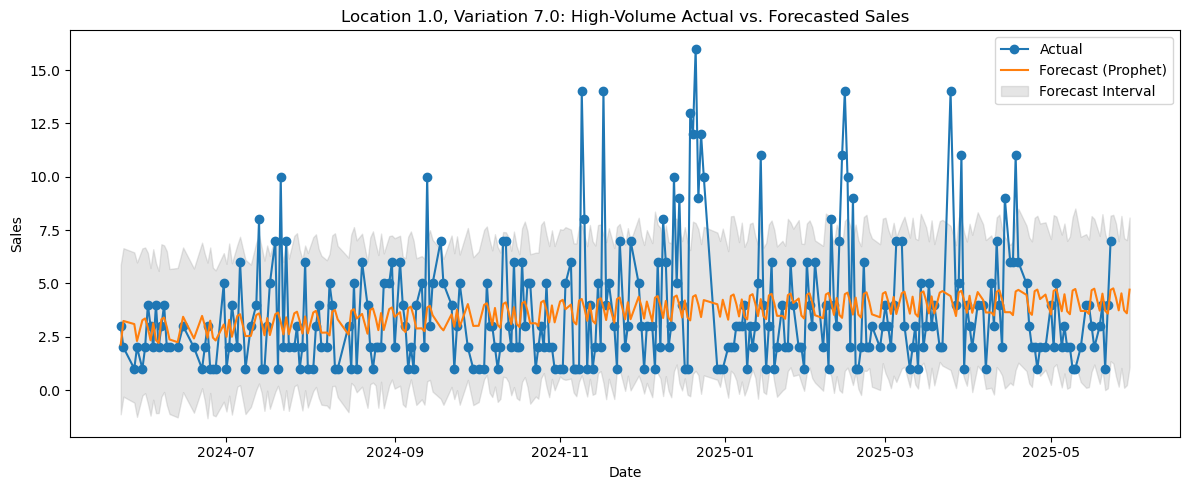

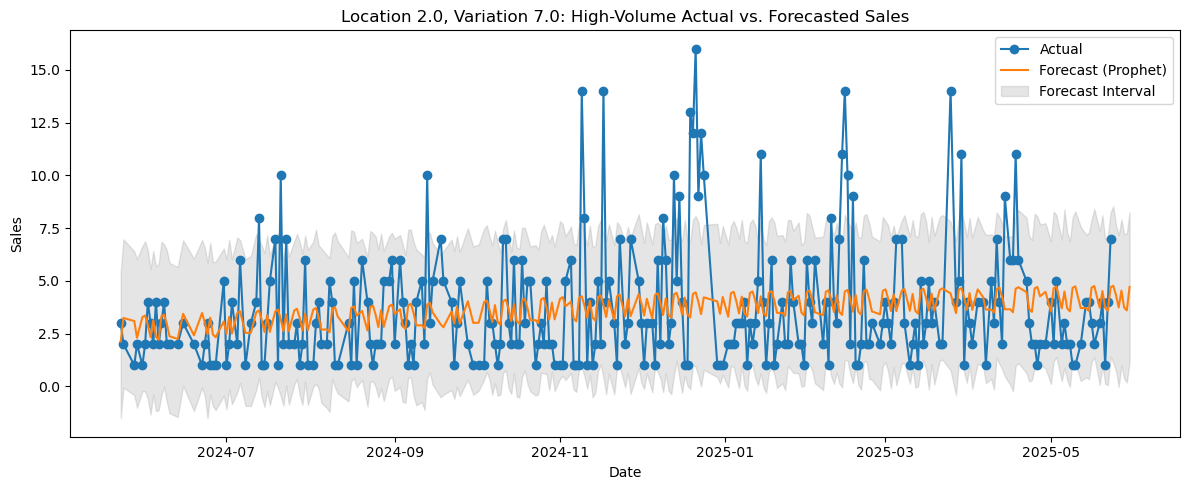

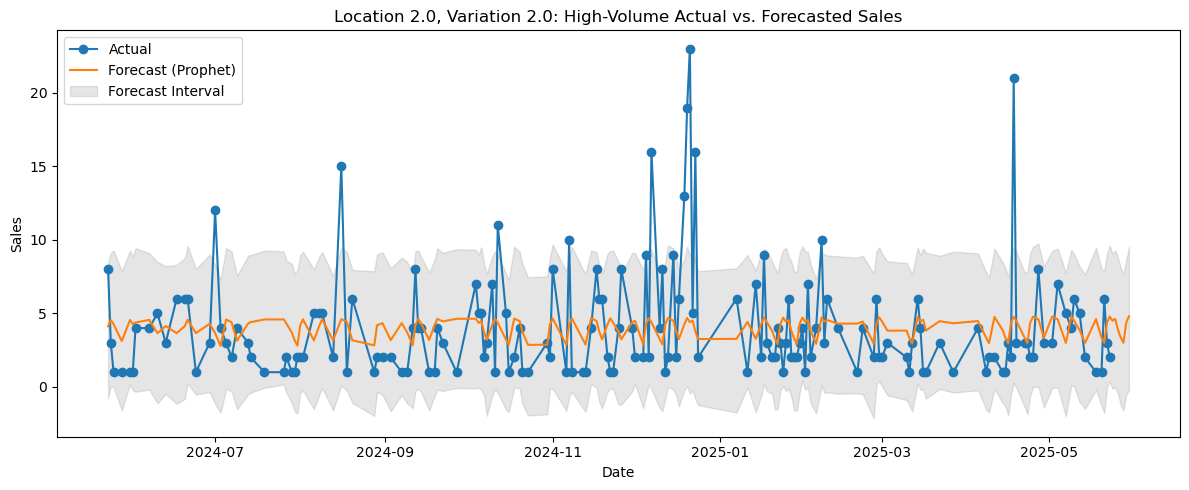

In [109]:
for key in top_keys:
    loc, var = key
    actual = prophet_forecasts[key]['actual']
    forecast = prophet_forecasts[key]['forecast']
    plt.figure(figsize=(12, 5))
    plt.plot(actual['ds'], actual['y'], label='Actual', marker='o')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast (Prophet)', linestyle='-')
    plt.fill_between(
        forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2, label='Forecast Interval'
    )
    plt.title(f'Location {loc}, Variation {var}: High-Volume Actual vs. Forecasted Sales')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()
